In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam 
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from keras.utils import plot_model
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

2024-06-12 08:45:21.090278: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 08:45:21.090429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 08:45:21.223356: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import tensorflow as tf
from PIL import Image
import numpy as np


In [4]:
def preprocess_image(image_file, img_size):
    image = Image.open(image_file).convert("RGB")  # Преобразуем изображение в RGB
    image = image.resize((img_size, img_size))
    image = np.array(image) / 255.0  # Нормализуем изображение к диапазону [0, 1]
    return image


In [5]:
def data_generator(low_res_dir, high_res_dir, img_size):
    low_res_files = sorted(os.listdir(low_res_dir))
    high_res_files = sorted(os.listdir(high_res_dir))
    
    for low_res_file, high_res_file in zip(low_res_files, high_res_files):
        if low_res_file.endswith(('png', 'jpg', 'jpeg')) and high_res_file.endswith(('png', 'jpg', 'jpeg')):
            low_res_image_file = os.path.join(low_res_dir, low_res_file)
            high_res_image_file = os.path.join(high_res_dir, high_res_file)
            
            low_resolution = preprocess_image(low_res_image_file, img_size)
            high_resolution = preprocess_image(high_res_image_file, img_size)
            
            yield low_resolution, high_resolution


In [6]:
def prepare_dataset(low_res_dir, high_res_dir, img_size, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(low_res_dir, high_res_dir, img_size),
        output_signature=(
            tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32)
        )
    )
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


In [7]:
low_res_dir = '/kaggle/input/image-super-resolution/dataset/train/low_res'
high_res_dir = '/kaggle/input/image-super-resolution/dataset/train/high_res'
img_size = 256
batch_size = 8

train_dataset = prepare_dataset(low_res_dir, high_res_dir, img_size, batch_size)

# Тестирование генератора данных
X_realA, X_realB = next(iter(train_dataset))
print("Shape of X_realA:", X_realA.shape)  # Должно быть (batch_size, img_size, img_size, 3)
print("Shape of X_realB:", X_realB.shape)  # Должно быть (batch_size, img_size, img_size, 3)


Shape of X_realA: (8, 256, 256, 3)
Shape of X_realB: (8, 256, 256, 3)


In [8]:
low_res, high_res = next(iter(train_dataset))

In [9]:
def plot_images(a = 4):
    
    for i in range(a):
        plt.figure(figsize = (10,10))
        plt.subplot(121)
        plt.title('high resolution')
        plt.imshow(high_res[i] )

        plt.subplot(122)
        plt.title('low resolution')
        plt.imshow(low_res[i])
        plt.show()

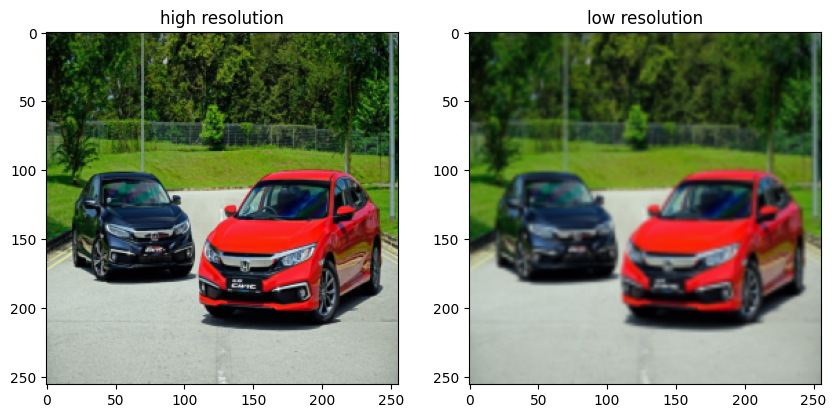

In [10]:
plot_images(1)

In [11]:

def define_discriminator(image_shape = (256, 256, 3)):
    init = RandomNormal(stddev=0.02)
    in_src_image = Input(shape=image_shape, name = 'input_image')
    in_target_image = Input(shape=image_shape, name='target_image')
    merged = Concatenate()([in_src_image, in_target_image])

    d = Conv2D(64, (4,4), strides = (2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(negative_slope=0.2)(d)

    d = Conv2D(128, (4,4), strides = (2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(negative_slope=0.2)(d)

    d = Conv2D(256, (4,4), strides = (2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(negative_slope=0.2)(d)

    d = Conv2D(512, (4,4), strides = (2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(negative_slope=0.2)(d)
        
#     d = Conv2D(512, (4,4), strides = (2,2), padding='same', kernel_initializer=init)(d)
#     d = BatchNormalization()(d)
#     d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(1, (4, 4), padding='same', kernel_initializer = init)(d)
    patch_out = Activation('sigmoid')(d)

    model = Model([in_src_image, in_target_image], patch_out)
    return model


    



In [12]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
        init = RandomNormal(stddev=0.02)

        g = Conv2D(n_filters, (4, 4), strides =(2, 2), padding = 'same', kernel_initializer = init)(layer_in)

        if batchnorm:
            g = BatchNormalization()(g, training = True)

        g = LeakyReLU(negative_slope=0.2)(g)
        return g

def decoder_block(layer_in, skip_in, n_filters, dropout = True):
        init = RandomNormal(stddev=0.02)

        g = Conv2DTranspose(n_filters, (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = init)(layer_in)
        g = BatchNormalization()(g, training = True)
        if dropout:
            g = Dropout(0.5)(g, training=True)
        g = Concatenate()([g, skip_in])

        g = Activation('relu')(g)
        return g

In [13]:

def define_generator(image_shape=(256, 256, 3)):

    init = RandomNormal(stddev=0.02)

    in_image = Input(shape = image_shape)

    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)

    b = Conv2D(512, (4,4), strides = (2, 2), padding = 'same', kernel_initializer = init)(e7)
    b = Activation('relu')(b)

    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout = False)
    d5 = decoder_block(d4, e3, 256, dropout = False)
    d6 = decoder_block(d5, e2, 128, dropout = False)
    d7 = decoder_block(d6, e1, 64, dropout = False)

    g = Conv2DTranspose(3, (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = init)(d7)
    out_image = Activation('tanh')(g)

    model = Model(in_image, out_image)
    return model

In [14]:
from tensorflow.keras.losses import BinaryCrossentropy
loss_object = BinaryCrossentropy(from_logits=False)
generator_optimizer = Adam(2e-4, beta_1=0.5, beta_2 = 0.999)
discriminator_optimizer = Adam(2e-4, beta_1=0.5, beta_2 = 0.999)

LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [15]:

def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                              generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                   discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                  discriminator.trainable_variables))

In [16]:
import time
def fit(train_ds, epochs, save_weights_path):
    for epoch in range(epochs):
        start = time.time()

        print("Epoch: ", epoch + 1)

        # Обучение на каждой батче данных
        for n, (input_image, target) in train_ds.enumerate():
            gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(input_image, target, epoch)
            print(f"Batch {n + 1}: Gen Total Loss: {gen_total_loss:.4f}, Gen GAN Loss: {gen_gan_loss:.4f}, Gen L1 Loss: {gen_l1_loss:.4f}, Disc Loss: {disc_loss:.4f}")

        # Сохранение весов после каждой эпохи
        generator.save_weights(save_weights_path)
        print(f'Time taken for epoch {epoch + 1} is {time.time() - start:.2f} sec\n')


In [17]:
img_shape = (256, 256, 3)
discriminator = define_discriminator(img_shape)
generator = define_generator(img_shape)

In [18]:
import tensorflow as tf

def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

# Make sure to redefine generator_optimizer and discriminator_optimizer variables

# Example usage of fit function
fit(train_dataset, epochs=30, save_weights_path='SRPix2PixGan.weights.h5')


Epoch:  1
Batch 1: Gen Total Loss: 46.6868, Gen GAN Loss: 0.9490, Gen L1 Loss: 0.4574, Disc Loss: 1.6672
Batch 2: Gen Total Loss: 54.9805, Gen GAN Loss: 1.9642, Gen L1 Loss: 0.5302, Disc Loss: 3.8286
Batch 3: Gen Total Loss: 62.0338, Gen GAN Loss: 1.0383, Gen L1 Loss: 0.6100, Disc Loss: 1.9036
Batch 4: Gen Total Loss: 47.0823, Gen GAN Loss: 0.8044, Gen L1 Loss: 0.4628, Disc Loss: 1.4741
Batch 5: Gen Total Loss: 33.7009, Gen GAN Loss: 0.7835, Gen L1 Loss: 0.3292, Disc Loss: 1.3347
Batch 6: Gen Total Loss: 34.2994, Gen GAN Loss: 0.8609, Gen L1 Loss: 0.3344, Disc Loss: 1.2535
Batch 7: Gen Total Loss: 35.4449, Gen GAN Loss: 0.9580, Gen L1 Loss: 0.3449, Disc Loss: 1.2412
Batch 8: Gen Total Loss: 36.0748, Gen GAN Loss: 0.9872, Gen L1 Loss: 0.3509, Disc Loss: 1.2528
Batch 9: Gen Total Loss: 30.8171, Gen GAN Loss: 1.0832, Gen L1 Loss: 0.2973, Disc Loss: 1.2983
Batch 10: Gen Total Loss: 29.0403, Gen GAN Loss: 0.9383, Gen L1 Loss: 0.2810, Disc Loss: 1.2143
Batch 11: Gen Total Loss: 23.9314, Gen 

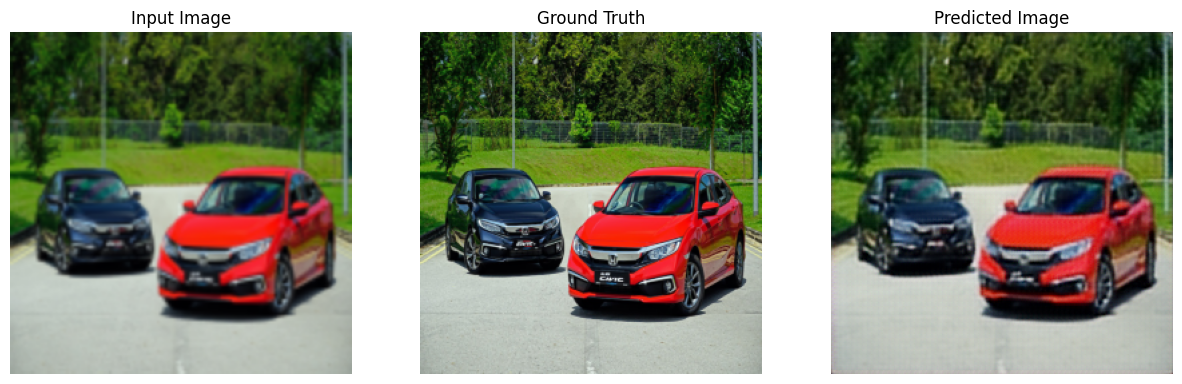

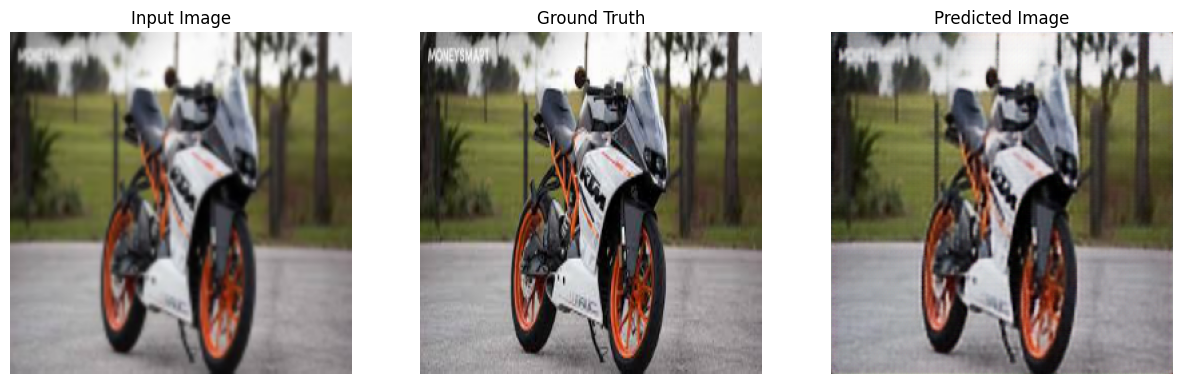

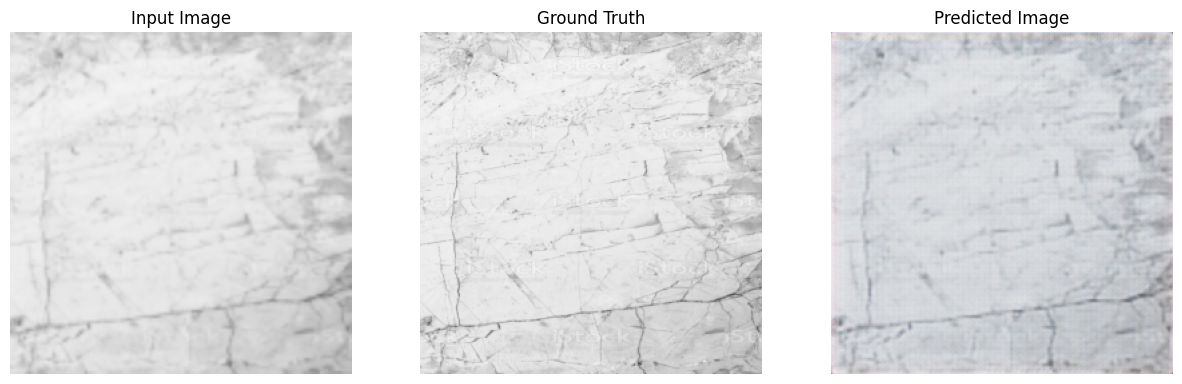

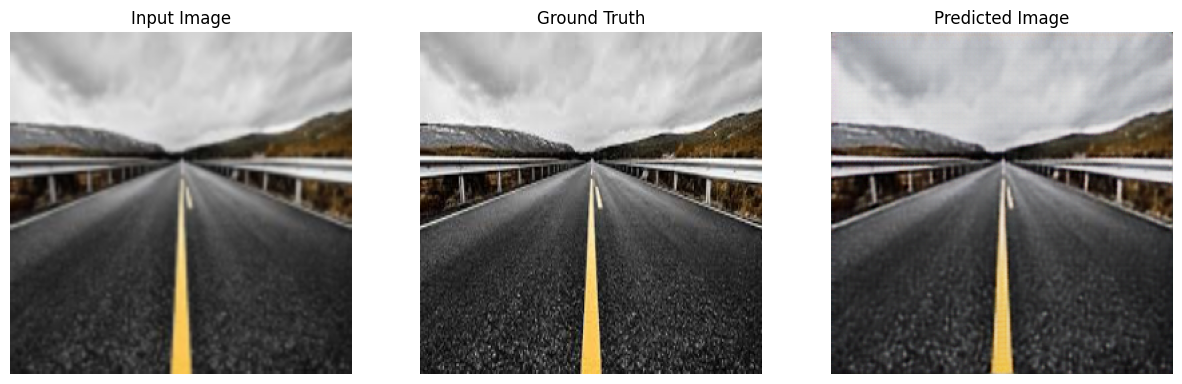

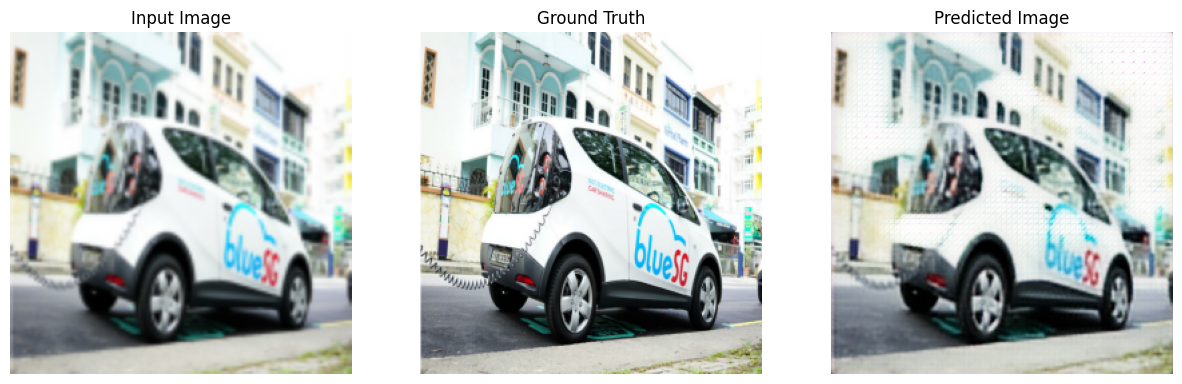

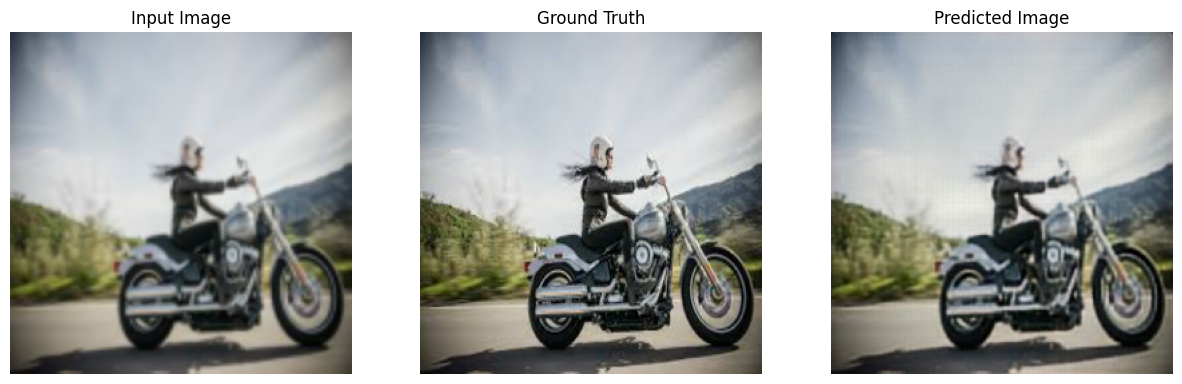

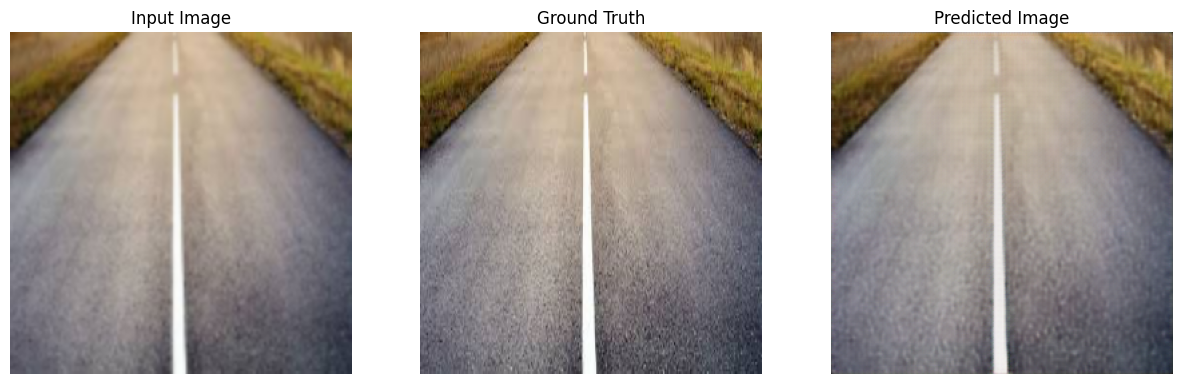

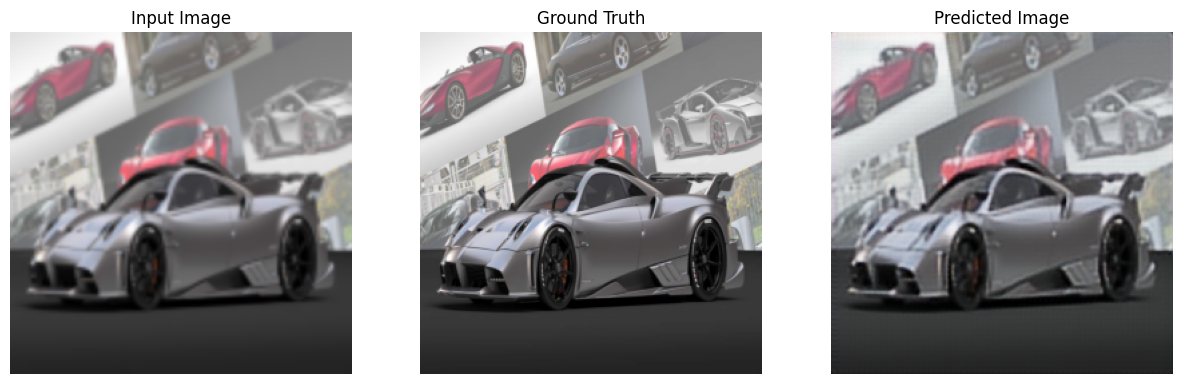

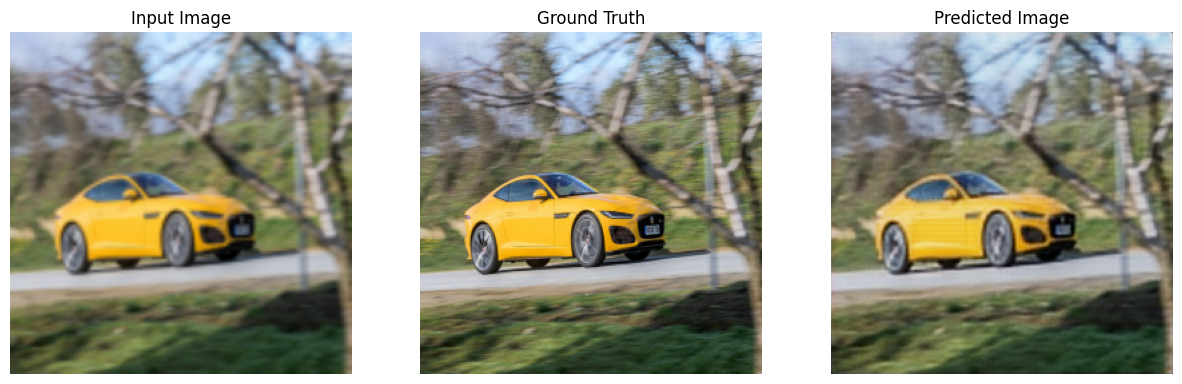

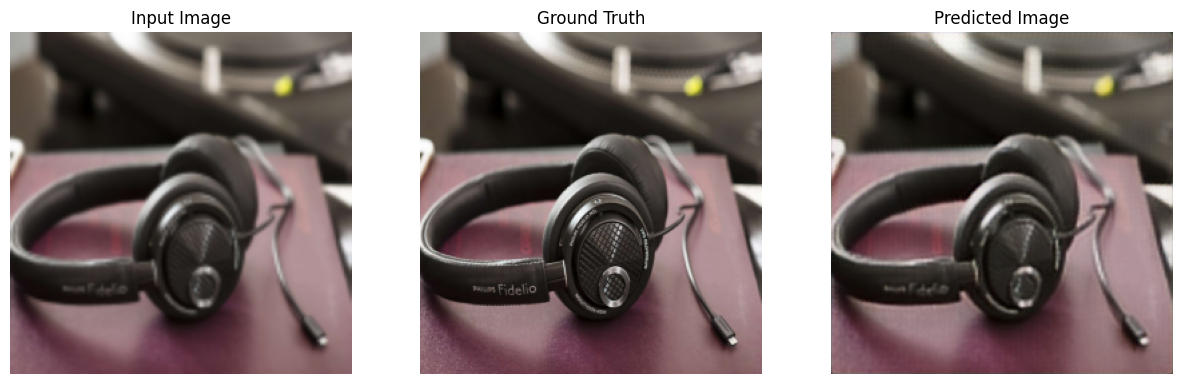

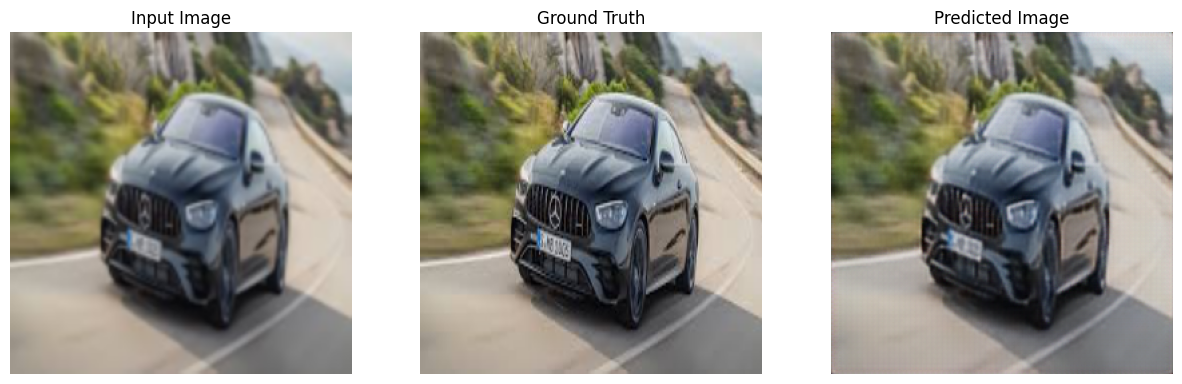

In [19]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

for example_input, example_target in (train_dataset).take(11):
    generate_images(generator, example_input, example_target)

In [22]:
generator.save("Pix2PixSR.h5") 

In [22]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [46]:
import tensorflow as tf
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import os

# Функция для загрузки изображений и их предобработки
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)  # Указываем channels=3 для RGB изображений
    image = tf.image.convert_image_dtype(image, tf.float32)  # Нормализация к диапазону [0, 1]
    image = (image - 0.5) * 2  # Нормализация к диапазону [-1, 1]
    image = tf.image.resize(image, [256, 256])  # Изменение размера изображения
    return image

# Функция для загрузки датасета
def load_dataset(directory, batch_size):
    file_paths = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset

# Функция для вычисления PSNR
def compute_psnr(original, generated):
    return tf.image.psnr(original, generated, max_val=255)

# Функция для вычисления SSIM
def compute_ssim(original, generated):
    return tf.image.ssim(original, generated, max_val=255)

# Функция оценки модели
def evaluate_model(model, dataset):
    psnr_values = []
    ssim_values = []

    for input_image, target in dataset:
        prediction = model(input_image, training=False)
        psnr_value = compute_psnr(target, prediction)
        ssim_value = compute_ssim(target, prediction)

        psnr_values.append(psnr_value.numpy())
        ssim_values.append(ssim_value.numpy())

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f'Average PSNR: {avg_psnr}')
    print(f'Average SSIM: {avg_ssim}')

    return avg_psnr, avg_ssim

# Пути к директориям с изображениями
high_res_path = '/kaggle/input/image-super-resolution/dataset/val/high_res'
low_res_path = '/kaggle/input/image-super-resolution/dataset/val/low_res'

# Загрузка датасетов
low_res_ds = load_dataset(low_res_path, batch_size=1)
high_res_ds = load_dataset(high_res_path, batch_size=1)

# Оценка модели
evaluate_model(generator, zip(low_res_ds, high_res_ds))


Average PSNR: 55.56418991088867
Average SSIM: 0.9679283499717712


(55.56419, 0.96792835)